In [38]:
import sys
# adding notebooks to the system path
sys.path.insert(0, '/home/southark/notebooks')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm
import scanpy as sc
import scipy

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2 
%matplotlib inline

from perturbseq import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from hits.visualize import interactive

In [40]:
import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

In [41]:
rpe1_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240309_RPE1_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
rpe1_mean_pop.genes.index.name = 'gene_id'

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 7.282954216003418s.
Done.


In [42]:
fibro_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])
fibro_mean_pop.genes.index.name = 'gene_id'

Loading matrix...
Available keys: ['/cell_list', '/gene_list', '/matrix', '/normalized_matrix_adj_p', '/normalized_matrix_masked', '/normalized_matrix_p']
Loading metadata...
Done in 4.552211284637451s.
Done.


In [43]:
bulk_codes = dict()
bulk_codes['rpe1'] = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_rpe1_bulk_codes.csv', index_col=0)
bulk_codes['fibro'] = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_codes.csv', index_col=0)

In [44]:
bulk_comps = dict()
bulk_comps['rpe1'] = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_rpe1_bulk_comps.csv', index_col=0)
bulk_comps['fibro'] = pd.read_csv('/data/norman/southark/tfs_standardized/20240331_fibroblast_bulk_comps.csv', index_col=0)

In [45]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
fibro_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [46]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_rpe1_guides.csv', index_col=0)
rpe1_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [47]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

In [48]:
guide_library['masked_active_fibro'] = fibro_mean_pop.cells['masked_active']
guide_library['expanded_masked_active_fibro'] = fibro_mean_pop.cells['expanded_masked_active']
guide_library['masked_active_fibro'].fillna(False, inplace=True)
guide_library['expanded_masked_active_fibro'].fillna(False, inplace=True)

/tmp/ipykernel_837923/928205125.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active_fibro'].fillna(False, inplace=True)
/tmp/ipykernel_837923/928205125.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  guide_library['masked_active_fibro'].fillna(False, inplace=True)
/tmp/ipykernel

In [49]:
guide_library['masked_active_rpe1'] = rpe1_mean_pop.cells['masked_active']
guide_library['expanded_masked_active_rpe1'] = rpe1_mean_pop.cells['expanded_masked_active']
guide_library['masked_active_rpe1'].fillna(False, inplace=True)
guide_library['expanded_masked_active_rpe1'].fillna(False, inplace=True)

/tmp/ipykernel_837923/2314786599.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  guide_library['masked_active_rpe1'].fillna(False, inplace=True)
/tmp/ipykernel_837923/2314786599.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [50]:
guide_library['de_genes_fibro'] = fibro_mean_pop.cells['de_genes']
guide_library['log_de_genes_fibro'] = np.log10(1+fibro_mean_pop.cells['de_genes'])

In [51]:
guide_library['de_genes_rpe1'] = rpe1_mean_pop.cells['de_genes']
guide_library['log_de_genes_rpe1'] = np.log10(1+rpe1_mean_pop.cells['de_genes'])

### Cellpopulation conversion and cleanup stuff

In [52]:
# rpe1_full_pop = sc.read_h5ad('/data/norman/southark/tfs_standardized/240308_RPE1_CRISPRa_final_population.h5ad')
# rpe1_full_pop = rpe1_full_pop[rpe1_full_pop.obs['num_cells']==1].copy()
# rpe1_full_pop = CellPopulation(pd.DataFrame(rpe1_full_pop.X.todense().A, index=rpe1_full_pop.obs.index, columns=rpe1_full_pop.var.index), rpe1_full_pop.obs, rpe1_full_pop.var, calculate_statistics=True)

In [53]:
# fibro_full_pop = sc.read_h5ad('/data/norman/southark/tfs_standardized/240308_fibroblast_CRISPRa_final_pop.h5ad')
# fibro_full_pop = fibro_full_pop[fibro_full_pop.obs['num_cells']==1].copy()
# fibro_full_pop = CellPopulation(pd.DataFrame(fibro_full_pop.X.todense().A, index=fibro_full_pop.obs.index, columns=fibro_full_pop.var.index), fibro_full_pop.obs, fibro_full_pop.var, calculate_statistics=True)

In [54]:
# rpe1_full_pop.to_hdf('/scratch/southark/20241205_rpe1_single_cell_pop.hdf', store_normalized_matrix=True)

In [55]:
# fibro_full_pop.to_hdf('/scratch/southark/20241205_fibro_single_cell_pop.hdf', store_normalized_matrix=True)

In [56]:
# good_guides_rpe1 = guide_library.query('masked_active_rpe1 or expanded_masked_active_rpe1').index
# good_guides_fibro = guide_library.query('masked_active_fibro or expanded_masked_active_fibro').index

In [57]:
# rpe1_full_pop = CellPopulation.from_hdf('/scratch/southark/20241205_rpe1_single_cell_pop.hdf')

In [58]:
# good_guides = guide_library.query('masked_active_rpe1 or expanded_masked_active_rpe1').index
# good_cells = rpe1_full_pop.cells.query('guide_identity in @good_guides').index

# rpe1_full_pop.cells.loc[good_cells, 'active'] = True
# rpe1_full_pop.cells['active'].fillna(False, inplace=True)

In [59]:
# fibro_full_pop = CellPopulation.from_hdf('/scratch/southark/20241205_fibro_single_cell_pop.hdf')

In [60]:
# good_guides = guide_library.query('masked_active_fibro or expanded_masked_active_fibro').index
# good_cells = fibro_full_pop.cells.query('guide_identity in @good_guides').index

# fibro_full_pop.cells.loc[good_cells, 'active'] = True
# fibro_full_pop.cells['active'].fillna(False, inplace=True)

In [61]:
# import scanpy as sc
# import anndata as ad

# def convert_cellpop_to_adata(cell_population):
#     """
#     Convert a perturb-seq CellPopulation object to AnnData
    
#     Parameters
#     ----------
#     cell_population : CellPopulation
#         The perturb-seq cell population object
        
#     Returns
#     -------
#     AnnData
#         Converted AnnData object with preserved cell and gene metadata
#     """
#     # Create AnnData object from the expression matrix
#     adata = ad.AnnData(
#         X=cell_population.matrix.values,
#         obs=cell_population.cells,
#         var=pd.DataFrame(index=cell_population.matrix.columns)
#     )
    
#     # Ensure the matrix genes are properly set as var_names
#     adata.var_names = cell_population.matrix.columns
    
#     # Make sure obs_names are set correctly
#     adata.obs_names = cell_population.cells.index
    
#     # Add any additional metadata from the cell population if available
#     if hasattr(cell_population, 'uns'):
#         adata.uns = cell_population.uns.copy()
        
#     return adata

# # # Convert your cell population
# # adata_fibro = convert_cellpop_to_adata(fibro_full_pop)

# # Optional: Basic quality check
# def check_adata_conversion(original_pop, adata):
#     """
#     Verify the conversion was successful
#     """
#     checks = {
#         "Shape matches": original_pop.matrix.shape == adata.shape,
#         "Cell names preserved": all(original_pop.cells.index == adata.obs_names),
#         "Gene names preserved": all(original_pop.matrix.columns == adata.var_names)
#     }
    
#     print("\nConversion Quality Checks:")
#     for check, result in checks.items():
#         print(f"{check}: {'✓' if result else '✗'}")
    
#     return all(checks.values())

# # # Run the check
# # success_fibro = check_adata_conversion(fibro_full_pop, adata_fibro)

In [62]:
# #save the gene name mapping for later
# fibro_gene_names = fibro_full_pop.genes['gene_name']
# rpe1_gene_names = rpe1_full_pop.genes['gene_name']

In [63]:
# # Convert your cell population
# adata_fibro = convert_cellpop_to_adata(fibro_full_pop)
# # Run the check
# success_fibro = check_adata_conversion(fibro_full_pop, adata_fibro)

# adata_fibro.var['gene_names'] = fibro_gene_names

# adata_fibro.write('/data/norman/southark/tfs_standardized/250202_fibro_singlecell_adata.h5ad')

# del fibro_full_pop

In [64]:
# # Convert your cell population
# adata_rpe1 = convert_cellpop_to_adata(rpe1_full_pop)
# # Run the check
# success_rpe1 = check_adata_conversion(rpe1_full_pop, adata_rpe1)

# adata_rpe1.var['gene_names'] = rpe1_gene_names

# adata_rpe1.write('/data/norman/southark/tfs_standardized/250202_RPE1_singlecell_adata.h5ad')

# del rpe1_full_pop

In [65]:
# del adata_rpe1
# del adata_fibro

## Read in scanpy files for single cell populations

In [ ]:
adata_fibro = sc.read_h5ad('/data/norman/southark/tfs_standardized/250202_fibro_singlecell_adata.h5ad')
adata_rpe1 = sc.read_h5ad('/data/norman/southark/tfs_standardized/250202_RPE1_singlecell_adata.h5ad')

Map ensembl ids to gene names so that we can identify targets of guides

In [31]:
mapper = merged_series = pd.concat([
    adata_fibro.var['gene_names'],
    adata_rpe1.var['gene_names']
]).drop_duplicates()

inverse_mapper = pd.Series({v: k for k,v in mapper.items()})

In [32]:
guide_library['target_gene_id'] = guide_library['target_gene'].map(inverse_mapper)

In [33]:
guide_library['target_gene_id'].isnull().any()

False

Restrict to guides that clustering analysis identified as active

In [34]:
adata_fibro = adata_fibro[adata_fibro.obs.query('active or control').index, :].copy()
adata_rpe1 = adata_rpe1[adata_rpe1.obs.query('active or control').index, :].copy()

Remove genes that aren't expressed. Also remove lncRNAs.

In [35]:
sc.pp.filter_genes(adata_fibro, min_cells=1)
sc.pp.filter_genes(adata_rpe1, min_cells=1)

In [36]:
adata_fibro = adata_fibro[:, ~(adata_fibro.var['gene_names'].astype(str).str.contains('\.')|adata_fibro.var['gene_names'].astype(str).str.contains('AS1')|adata_fibro.var['gene_names'].astype(str).str.contains('LINC')|adata_fibro.var['gene_names'].astype(str).str.contains('-DT'))].copy()

In [37]:
adata_rpe1 = adata_rpe1[:, ~(adata_rpe1.var['gene_names'].astype(str).str.contains('\.')|adata_rpe1.var['gene_names'].astype(str).str.contains('AS1')|adata_rpe1.var['gene_names'].astype(str).str.contains('LINC')|adata_rpe1.var['gene_names'].astype(str).str.contains('-DT'))].copy()

Mask the targets of guides in cells where they are perturbed with NaN so that they do not inflate CV estimates.

In [38]:
fibro_masked_coefs = pd.DataFrame(adata_fibro.X, index=adata_fibro.obs.index, columns=adata_fibro.var.index)

fibro_masked_coefs['target_gene_id'] = adata_fibro.obs['guide_identity'].map(lambda x: x.split('_')[0]).map(inverse_mapper).fillna('')
fibro_masked_coefs.set_index('target_gene_id', append=True, inplace=True)

# Iterate over the rows of the DataFrame
for row_index, row_data in tqdm(fibro_masked_coefs.iterrows()):
    # Extracting the Ensembl ID from the second level of the multi-index
    target_gene_id = row_index[1]

    # Check if the Ensembl ID is not an empty string
    if target_gene_id != "":
        # Set the corresponding column's value to np.nan
        if target_gene_id in fibro_masked_coefs.columns:
            fibro_masked_coefs.at[row_index, target_gene_id] = np.nan
            
fibro_masked_coefs = fibro_masked_coefs.droplevel(1)

29658it [00:07, 3906.57it/s] 


In [39]:
rpe1_masked_coefs = pd.DataFrame(adata_rpe1.X, index=adata_rpe1.obs.index, columns=adata_rpe1.var.index)

rpe1_masked_coefs['target_gene_id'] = adata_rpe1.obs['guide_identity'].map(lambda x: x.split('_')[0]).map(inverse_mapper).fillna('')
rpe1_masked_coefs.set_index('target_gene_id', append=True, inplace=True)

# Iterate over the rows of the DataFrame
for row_index, row_data in tqdm(rpe1_masked_coefs.iterrows()):
    # Extracting the Ensembl ID from the second level of the multi-index
    target_gene_id = row_index[1]

    # Check if the Ensembl ID is not an empty string
    if target_gene_id != "":
        # Set the corresponding column's value to np.nan
        if target_gene_id in rpe1_masked_coefs.columns:
            rpe1_masked_coefs.at[row_index, target_gene_id] = np.nan
            
rpe1_masked_coefs = rpe1_masked_coefs.droplevel(1)

35125it [00:01, 26187.58it/s]


In final analysis, we restrict only to guides that have good representation in both fibroblast and RPE1 datasets so that we can compare effects of a common set of perturbations.

In [40]:
fibro_guide_counts = adata_fibro.obs.groupby('guide_identity').size().sort_values()
fibro_well_represented = fibro_guide_counts[fibro_guide_counts>=10].index

/tmp/ipykernel_667241/1750657736.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fibro_guide_counts = adata_fibro.obs.groupby('guide_identity').size().sort_values()


In [41]:
rpe1_guide_counts = adata_rpe1.obs.groupby('guide_identity').size().sort_values()
rpe1_well_represented = rpe1_guide_counts[rpe1_guide_counts>=10].index

/tmp/ipykernel_667241/2501712323.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rpe1_guide_counts = adata_rpe1.obs.groupby('guide_identity').size().sort_values()


In [42]:
common_perturbations = np.intersect1d(fibro_well_represented,
                                      rpe1_well_represented)

In [43]:
fibro_control_std = fibro_masked_coefs.loc[adata_fibro.obs.query('control').index].std()
fibro_control_mean = fibro_masked_coefs.loc[adata_fibro.obs.query('control').index].mean()
fibro_control_cv = fibro_control_std/fibro_control_mean

active_common_idx = adata_fibro.obs.query('guide_identity in @common_perturbations and active').index
fibro_active_std = fibro_masked_coefs.loc[active_common_idx].std()
fibro_active_mean = fibro_masked_coefs.loc[active_common_idx].mean()
fibro_active_cv = fibro_active_std/fibro_active_mean

In [44]:
rpe1_control_std = rpe1_masked_coefs.loc[adata_rpe1.obs.query('control').index].std()
rpe1_control_mean = rpe1_masked_coefs.loc[adata_rpe1.obs.query('control').index].mean()
rpe1_control_cv = rpe1_control_std/rpe1_control_mean

active_common_idx = adata_rpe1.obs.query('guide_identity in @common_perturbations and active').index
rpe1_active_std = rpe1_masked_coefs.loc[active_common_idx].std()
rpe1_active_mean = rpe1_masked_coefs.loc[active_common_idx].mean()
rpe1_active_cv = rpe1_active_std/rpe1_active_mean

In [45]:
fibro_df = pd.DataFrame([fibro_control_cv, fibro_active_cv,
                   np.log10(fibro_control_mean), np.log10(fibro_active_mean)], index=['control_cv', 'active_cv', 'control_mean', 'active_mean']).T

fibro_df['gene_name'] = fibro_df.index.map(mapper)
fibro_df = fibro_df.set_index('gene_name')
fibro_df = fibro_df.dropna()

/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [46]:
rpe1_df = pd.DataFrame([rpe1_control_cv, rpe1_active_cv,
                   np.log10(rpe1_control_mean), np.log10(rpe1_active_mean)], index=['control_cv', 'active_cv', 'control_mean', 'active_mean']).T

rpe1_df['gene_name'] = rpe1_df.index.map(mapper)
rpe1_df = rpe1_df.set_index('gene_name')
rpe1_df = rpe1_df.dropna()

/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We do two corrections:

(1) There is a strong dependence of CV on mean. We compute "mean-corrected" CV estimates using a LOWESS filter. This provides an estimate of what the CV should be for a given mean expression level. To identify unexpectedly high variability, we then divide the observed value by this expected value. We call this "excess CV".

(2) Some genes are highly variable for reasons that have nothing to do with perturbations (e.g. cell cycle genes). To compensate for this, we estimate excess CV in control and perturbed cells and then compute the fold increase as an estimate of the effects of perturbations.

In [47]:
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess

def compute_excess_cv(df, condition='control'):
    """
    Compute excess CV for a given condition using LOWESS regression on log-transformed data
    
    Parameters:
    -----------
    df : pandas DataFrame
        Contains mean and cv columns for the condition
    condition : str
        Either 'control' or 'active'
        
    Returns:
    --------
    excess_cv : pandas Series
        Excess CV values for each gene (ratio of observed to expected)
    expected_cv : pandas Series
        Expected CV values from LOWESS fit
    """
    mean_col = f'{condition}_mean'
    cv_col = f'{condition}_cv'
    
    # Log transform CV for fitting (mean is already in log10 space)
    log_cv = np.log10(df[cv_col])
    
    # Compute LOWESS fit in log space
    log_expected = lowess(
        log_cv,
        df[mean_col],
        frac=0.05,
        it=3,
        return_sorted=False
    )
    
    # Transform back to linear space
    expected_cv = 10**log_expected
    
    # Compute excess CV as ratio
    excess_cv = df[cv_col] / expected_cv
    
    return excess_cv, expected_cv

def analyze_differential_variability(df):
    """
    Analyze differential variability between conditions
    
    Parameters:
    -----------
    df : pandas DataFrame
        Contains mean and cv columns for both conditions
        
    Returns:
    --------
    results_df : pandas DataFrame
        Contains analysis results including excess CV and z-scores
    """
    # Compute excess CV for both conditions
    control_excess_cv, control_expected = compute_excess_cv(df, 'control')
    active_excess_cv, active_expected = compute_excess_cv(df, 'active')
    
    # Z-score the log of excess CV values
    control_z = stats.zscore(np.log10(control_excess_cv))
    active_z = stats.zscore(np.log10(active_excess_cv))
    
    # Compute differential variability score
    diff_var_score = active_z - control_z
    
    # Compile results
    results_df = pd.DataFrame({
        'control_excess_cv': control_excess_cv,
        'active_excess_cv': active_excess_cv,
        'control_z': control_z,
        'active_z': active_z,
        'diff_var_score': diff_var_score,
        'control_expected_cv': control_expected,
        'active_expected_cv': active_expected
    })
    
    return results_df

def plot_analysis_results(df, results_df):
    """
    Create diagnostic plots for the analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    
    # Plot 1: Original CV ratio vs mean
    cv_ratio = df['active_cv'] / df['control_cv']
    axes[0,0].scatter(df['control_mean'], cv_ratio, alpha=0.5)
    axes[0,0].set_xlabel('Control Mean Expression (log10)')
    axes[0,0].set_ylabel('CV Ratio (Active/Control)')
    axes[0,0].set_title('Raw CV Ratio vs Expression Level')
    
    # Plot 2: LOWESS fits
    axes[0,1].scatter(df['control_mean'], np.log10(df['control_cv']), 
                     alpha=0.5, label='Control')
    axes[0,1].scatter(df['active_mean'], np.log10(df['active_cv']), 
                     alpha=0.5, label='Active')
    axes[0,1].scatter(df['control_mean'], np.log10(results_df['control_expected_cv']), label='Control Fit')
    axes[0,1].scatter(df['active_mean'], np.log10(results_df['active_expected_cv']), label='Active Fit')
    axes[0,1].set_xlabel('Mean Expression (log10)')
    axes[0,1].set_ylabel('CV (log10)')
    axes[0,1].legend()
    axes[0,1].set_title('LOWESS Fits of CV vs Expression')
    
    # Plot 3: Excess CV comparison (log scale)
    axes[1,0].scatter(np.log10(results_df['control_excess_cv']), 
                     np.log10(results_df['active_excess_cv']), 
                     alpha=0.5)
    axes[1,0].axline([0, 0], [1, 1], color='r', linestyle='--')
    axes[1,0].set_xlabel('Control log10(Excess CV)')
    axes[1,0].set_ylabel('Active log10(Excess CV)')
    axes[1,0].set_title('Excess CV Comparison')
    
    # Plot 4: Differential variability score distribution
    sns.histplot(results_df['diff_var_score'], kde=True, ax=axes[1,1])
    axes[1,1].set_xlabel('Differential Variability Score')
    axes[1,1].set_title('Distribution of Differential Variability Scores')
    
    # Plot 5: Z-score comparison
    axes[1,2].scatter(results_df['control_z'], results_df['active_z'], alpha=0.5)
    axes[1,2].axline([0, 0], [1, 1], color='r', linestyle='--')
    axes[1,2].set_xlabel('Control Z-score')
    axes[1,2].set_ylabel('Active Z-score')
    axes[1,2].set_title('Z-score Comparison')
    
    plt.tight_layout()
    return fig

def identify_variable_genes(results_df, quantile=0.99):
    """
    Identify genes with significantly increased variability
    
    Parameters:
    -----------
    results_df : pandas DataFrame
        Results from analyze_differential_variability
    quantile : float
        Quantile threshold for calling significant genes (e.g., 0.95 for top 5%)
        
    Returns:
    --------
    variable_genes : pandas DataFrame
        Genes with significantly increased variability in active condition
    threshold : float
        The differential variability score threshold used
    """
    threshold = np.quantile(results_df['diff_var_score'], quantile)
    variable_genes = results_df[results_df['diff_var_score'] > threshold].sort_values(
        'diff_var_score', ascending=False)
    return variable_genes


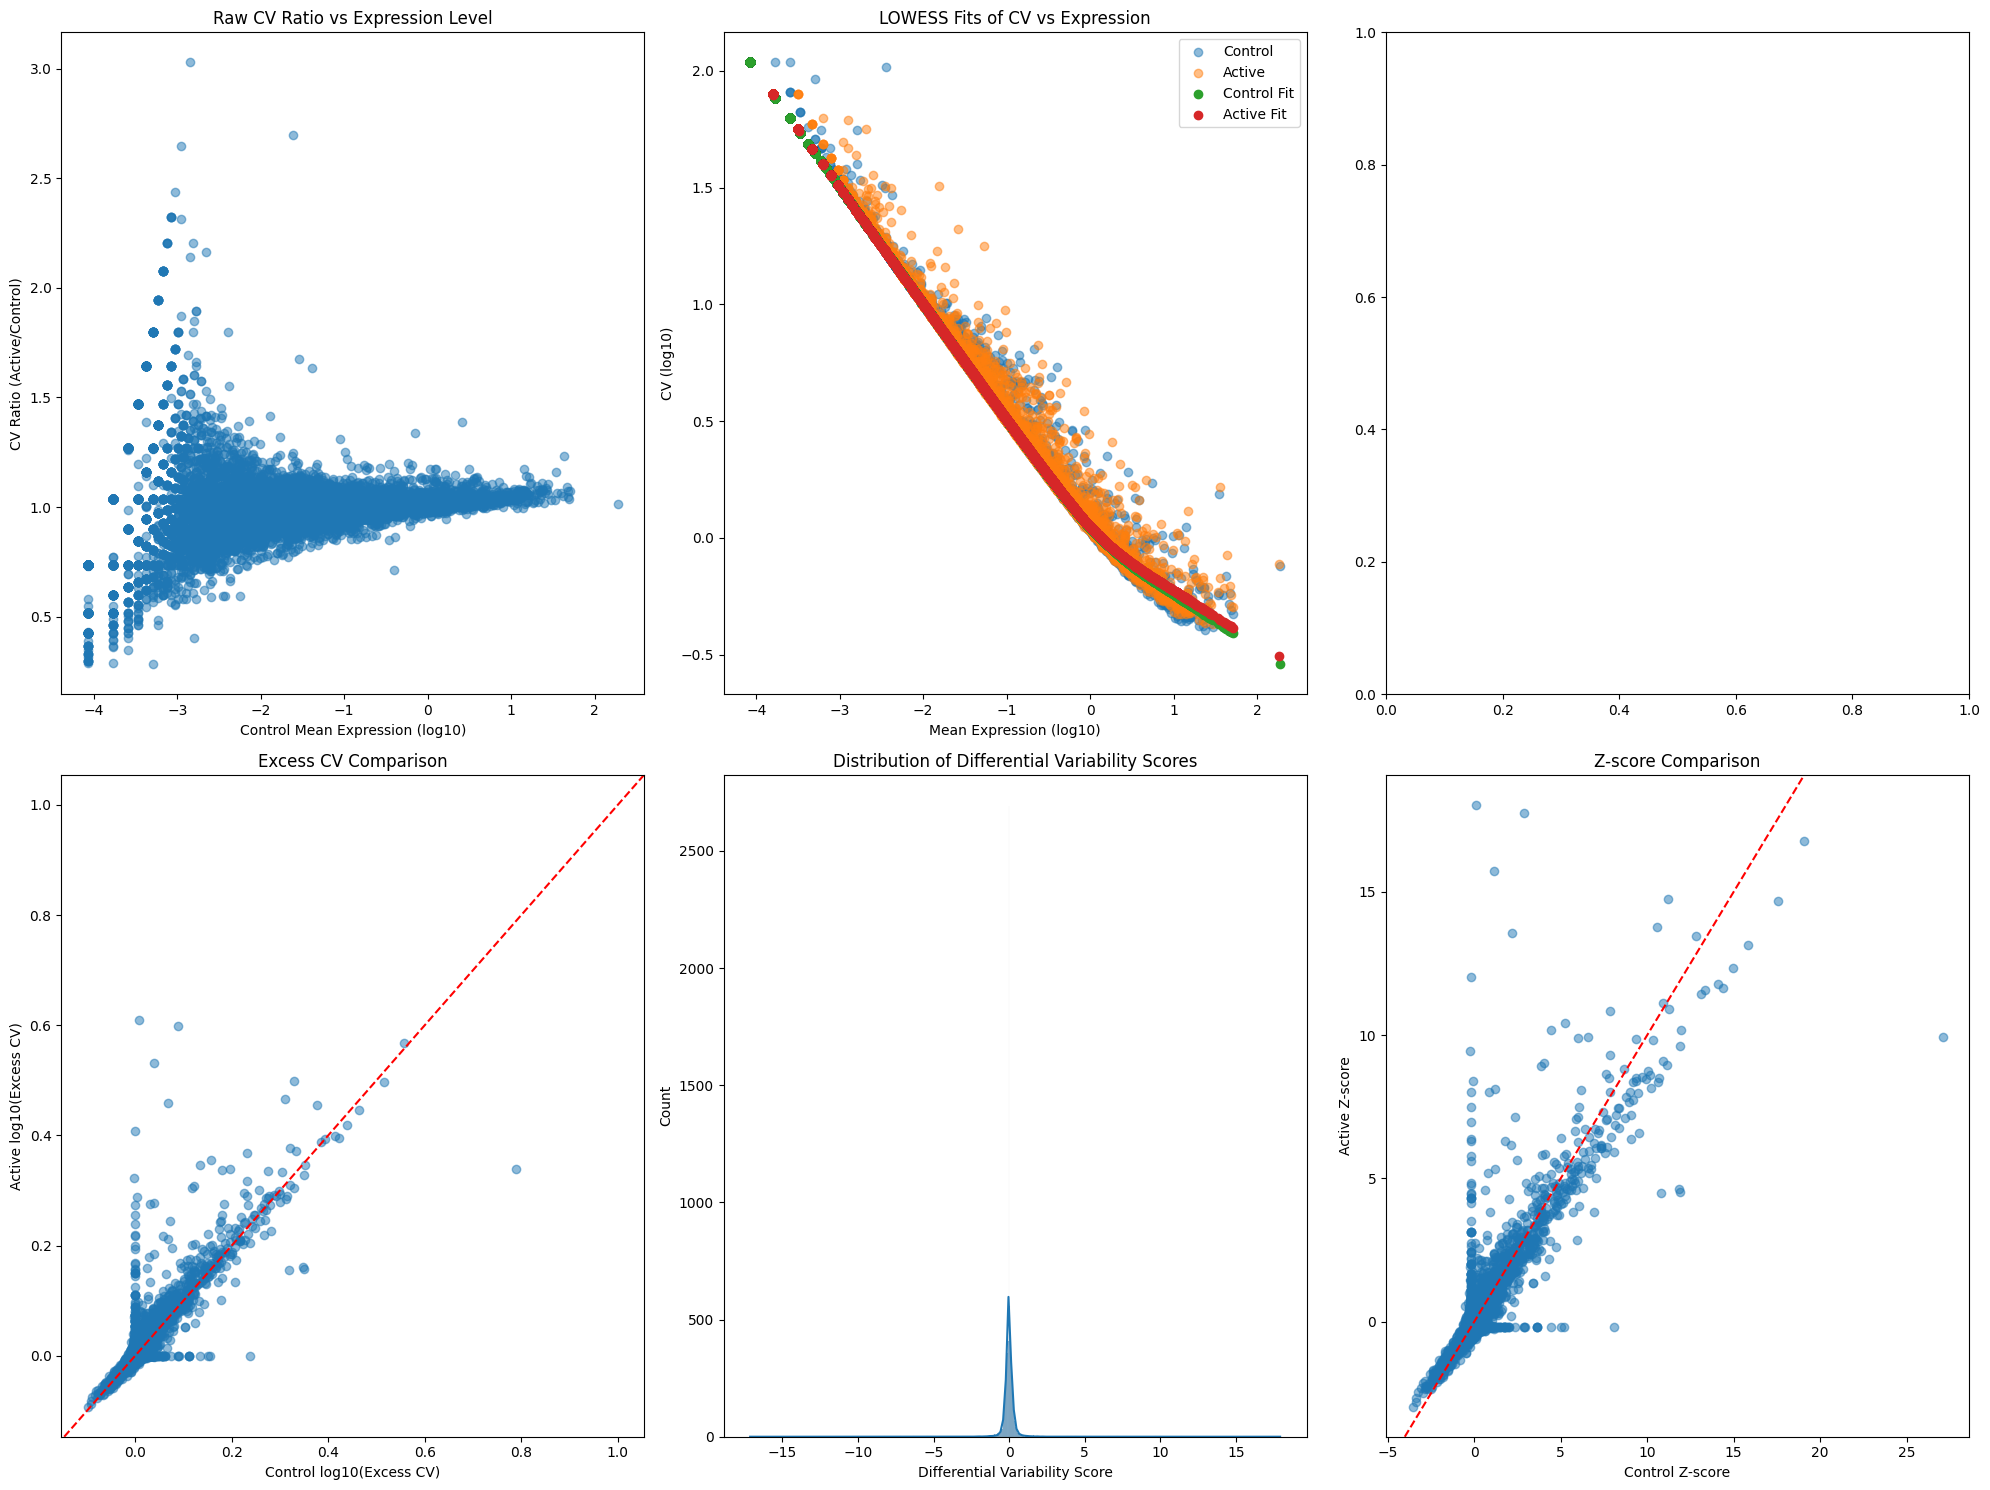

In [48]:
fibro_results_df = analyze_differential_variability(fibro_df)
fig = plot_analysis_results(fibro_df, fibro_results_df)
fibro_variable_genes = identify_variable_genes(fibro_results_df)
fibro_results_df['fold_excess_cv'] = (fibro_results_df['active_excess_cv']/fibro_results_df['control_excess_cv']).sort_values()

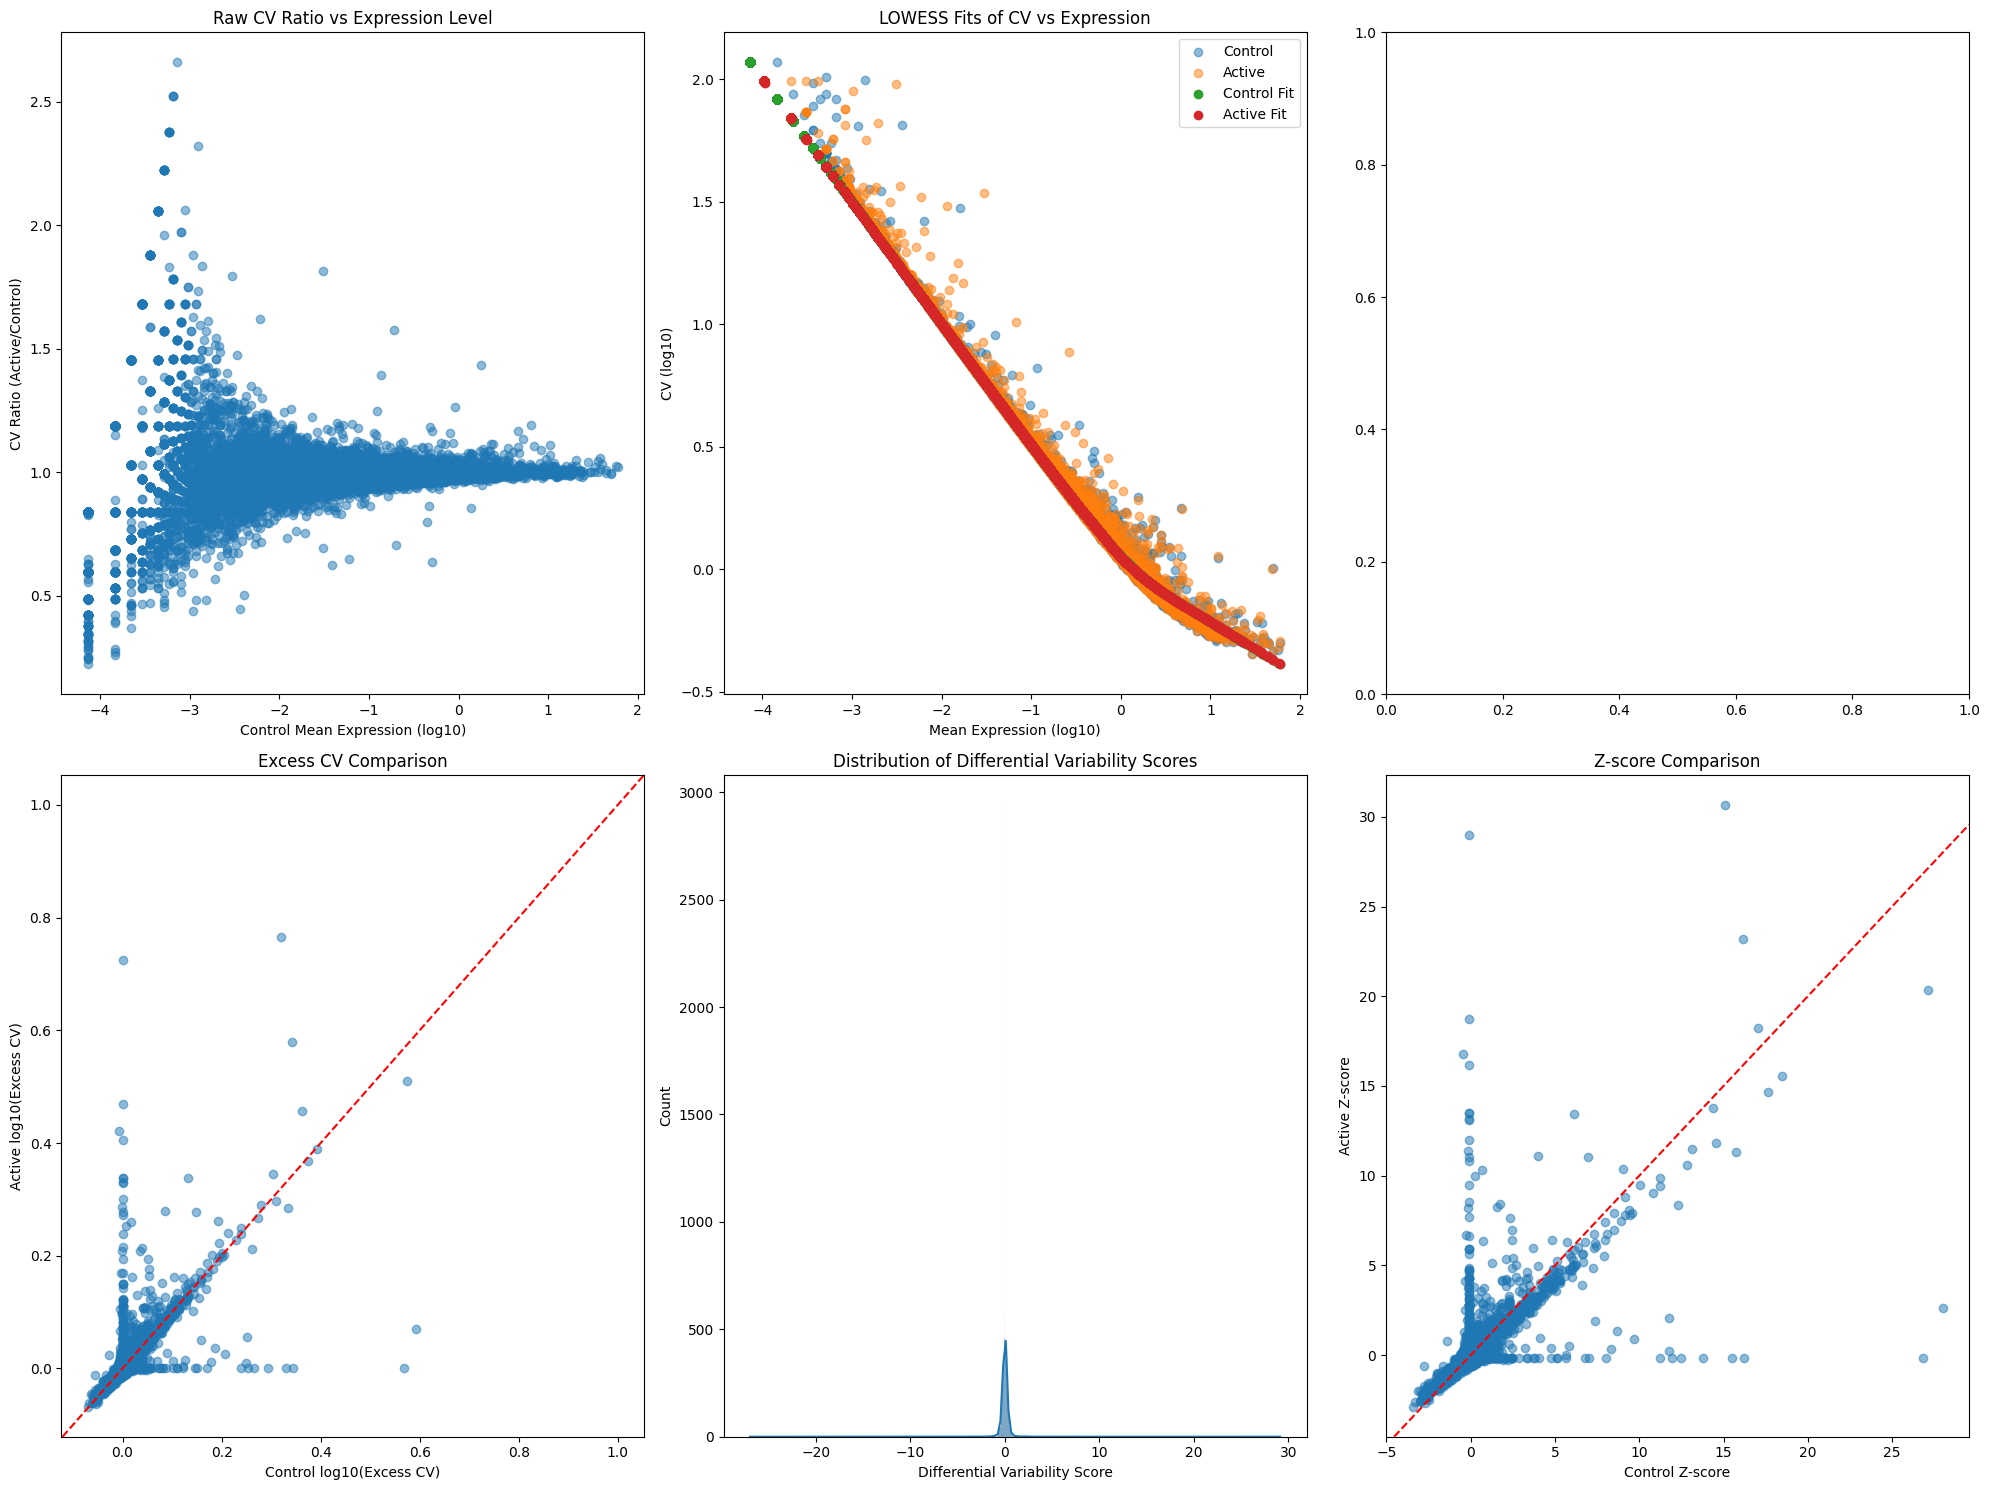

In [49]:
rpe1_results_df = analyze_differential_variability(rpe1_df)
fig = plot_analysis_results(rpe1_df, rpe1_results_df)
rpe1_variable_genes = identify_variable_genes(rpe1_results_df)
rpe1_results_df['fold_excess_cv'] = (rpe1_results_df['active_excess_cv']/rpe1_results_df['control_excess_cv']).sort_values()

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

def setup_publication_style():
    """Set up matplotlib style for publication-quality figures."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    colors = {
        'main_scatter': '#2c3e50',  # Dark blue-grey
        'fibro_only': '#6088C5',    # Dark blue
        'rpe1_only': '#5AC2B0',     # Bright blue
        'venn_colors': ['#6088C5', '#5AC2B0']  # Match the strip plots
    }
    
    FONT_SIZES = {
        'title': 12,
        'axis_label': 10,
        'tick_label': 9,
        'annotation': 8
    }
    
    return colors, FONT_SIZES

def get_axis_limits(df_both, df_fonly, df_ronly, xcol='plot_rpe1', ycol='plot_fibro', padding=0.1):
    """Calculate consistent axis limits across all plots based on the specified columns."""
    all_x = pd.concat([
        df_both[xcol],
        df_ronly[xcol]
    ])
    all_y = pd.concat([
        df_both[ycol],
        df_fonly[ycol]
    ])
    
    x_min, x_max = all_x.min(), all_x.max()
    y_min, y_max = all_y.min(), all_y.max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    x_lim = (x_min - padding * x_range, x_max + padding * x_range)
    y_lim = (y_min - padding * y_range, y_max + padding * y_range)
    
    return x_lim, y_lim

def label_points_2d(ax, data, xcol, ycol, labelcol='gene_name'):
    """Label all points in a 2D scatter directly at their positions."""
    if data.empty:
        return
    
    for _, row in data.iterrows():
        ax.text(
            row[xcol],
            row[ycol],
            row[labelcol],
            fontsize=8,
            color='#2c3e50',
            ha='left', va='bottom'
        )

def label_points_1d(ax, data, col, labelcol='gene_name', orientation='vertical'):
    """Label all points in a strip plot directly at their scatter positions."""
    if data.empty:
        return

    # Get the plotted points
    points = ax.collections[0].get_offsets()
    
    # Get the values we're looking for
    target_values = data[col].values
    
    # For each target value, find the matching point
    for value in target_values:
        if orientation == 'vertical':
            # Find all points with matching y-coordinate (within small tolerance)
            matches = points[np.isclose(points[:, 1], value, rtol=1e-10)]
            if len(matches) > 0:
                label = data[data[col] == value].iloc[0][labelcol]
                ax.text(
                    matches[0, 0],  # x position from the point
                    matches[0, 1],  # y position from the point
                    label,
                    fontsize=8,
                    color='#2c3e50',
                    ha='left', va='center'
                )
        else:  # horizontal
            # Find all points with matching x-coordinate (within small tolerance)
            matches = points[np.isclose(points[:, 0], value, rtol=1e-10)]
            if len(matches) > 0:
                label = data[data[col] == value].iloc[0][labelcol]
                ax.text(
                    matches[0, 0],  # x position from the point
                    matches[0, 1],  # y position from the point
                    label,
                    fontsize=8,
                    color='#2c3e50',
                    ha='left', va='bottom'
                )

def create_publication_figure(df, quantile=0.95, log=True, vmin=None):
    """Create the complete publication-quality figure using quantile-based thresholds.

    Splits the DataFrame based on presence (non-NaN) of fibro_excess_cv / rpe1_excess_cv:
      - df_both:    Genes measured in both Fibro and RPE-1
      - df_fonly:   Genes measured only in Fibro
      - df_ronly:   Genes measured only in RPE-1

    Adds columns:
      - 'fibro_cv_quantile' = rank of fibro_excess_cv (fraction in [0,1])
      - 'rpe1_cv_quantile'  = rank of rpe1_excess_cv (fraction in [0,1])
      - 'plot_fibro' and 'plot_rpe1' are created based on the `log` flag.

    Uses quantile-based thresholds T_fibro, T_rpe1 to classify high-variance outliers.

    Args:
        df (DataFrame): Input data with columns 'fibro_excess_cv' and 'rpe1_excess_cv'
        quantile (float): Quantile threshold for high variance genes.
        log (bool): If True, log-transform the values before plotting.
        vmin (float, optional): Minimum value for both x and y axes. If provided, the
            lower bound for both axes will be set to vmin.

    Returns:
        tuple: (figure, dict of hit gene lists)
            - figure: matplotlib figure object
            - hit_genes: dictionary containing lists of gene names for each category.
    """
    colors, FONT_SIZES = setup_publication_style()
    
    # ----- Add quantile columns -----
    df['fibro_cv_quantile'] = df['fibro_excess_cv'].rank(method='average', pct=True)
    df['rpe1_cv_quantile']  = df['rpe1_excess_cv'].rank(method='average', pct=True)
    
    # Calculate quantile-based thresholds using raw values
    T_fibro = df['fibro_excess_cv'].quantile(quantile)
    T_rpe1  = df['rpe1_excess_cv'].quantile(quantile)
    
    # Create plotting columns based on the log flag
    if log:
        df['plot_fibro'] = np.log10(df['fibro_excess_cv'])
        df['plot_rpe1'] = np.log10(df['rpe1_excess_cv'])
        xlabel = 'log₁₀(RPE-1 Excess CV)'
        ylabel = 'log₁₀(Fibroblast excess CV)'
    else:
        df['plot_fibro'] = df['fibro_excess_cv']
        df['plot_rpe1'] = df['rpe1_excess_cv']
        xlabel = 'RPE-1 Excess CV'
        ylabel = 'Fibroblast excess CV'
    
    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(5, 5, hspace=0.3, wspace=0.3)
    
    # Identify high variance indices for each cell type using raw values
    fibro_high_set = set(df.index[df['fibro_excess_cv'] > T_fibro])
    rpe1_high_set  = set(df.index[df['rpe1_excess_cv'] > T_rpe1])
    
    # Split data by whether each cell type is detected (non-NaN)
    df_both = df[(~df['fibro_excess_cv'].isna()) & (~df['rpe1_excess_cv'].isna())].copy()
    df_fonly = df[(~df['fibro_excess_cv'].isna()) & (df['rpe1_excess_cv'].isna())].copy()
    df_ronly = df[(df['fibro_excess_cv'].isna()) & (~df['rpe1_excess_cv'].isna())].copy()
    
    # Filter high variance genes in each subset (using raw values for thresholds)
    df_both_hv = df_both[
        (df_both['fibro_excess_cv'] > T_fibro) | 
        (df_both['rpe1_excess_cv'] > T_rpe1)
    ].copy()
    df_fonly_hv = df_fonly[df_fonly['fibro_excess_cv'] > T_fibro].copy()
    df_ronly_hv = df_ronly[df_ronly['rpe1_excess_cv'] > T_rpe1].copy()
    
    # Get consistent axis limits based on the chosen plotting columns
    x_lim, y_lim = get_axis_limits(df_both, df_fonly, df_ronly, xcol='plot_rpe1', ycol='plot_fibro')
    
    # Override lower limits with vmin if provided
    if vmin is not None:
        x_lim = (vmin, x_lim[1])
        y_lim = (vmin, y_lim[1])
    
    # Main scatter plot for genes detected in both cell types
    ax_main = fig.add_subplot(gs[1:4, 1:4])
    
    # Plot points that are not high variance in either cell type
    normal_points = df_both[
        (df_both['fibro_excess_cv'] <= T_fibro) & 
        (df_both['rpe1_excess_cv'] <= T_rpe1)
    ]
    ax_main.scatter(
        normal_points['plot_rpe1'],
        normal_points['plot_fibro'],
        c=colors['main_scatter'],
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='Normal Variance'
    )
    
    # Plot points that are high variance in Fibro only
    fibro_hv = df_both[
        (df_both['fibro_excess_cv'] > T_fibro) & 
        (df_both['rpe1_excess_cv'] <= T_rpe1)
    ]
    ax_main.scatter(
        fibro_hv['plot_rpe1'],
        fibro_hv['plot_fibro'],
        c=colors['fibro_only'],
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='Fibro High Variance'
    )
    
    # Plot points that are high variance in RPE1 only
    rpe1_hv = df_both[
        (df_both['rpe1_excess_cv'] > T_rpe1) & 
        (df_both['fibro_excess_cv'] <= T_fibro)
    ]
    ax_main.scatter(
        rpe1_hv['plot_rpe1'],
        rpe1_hv['plot_fibro'],
        c=colors['rpe1_only'],
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='RPE1 High Variance'
    )
    
    # Plot points that are high variance in both
    both_hv = df_both[
        (df_both['fibro_excess_cv'] > T_fibro) & 
        (df_both['rpe1_excess_cv'] > T_rpe1)
    ]
    ax_main.scatter(
        both_hv['plot_rpe1'],
        both_hv['plot_fibro'],
        c='#984EA3',  # Purple for overlap
        alpha=0.6,
        s=30,
        edgecolor='white',
        linewidth=0.5,
        label='Both High Variance'
    )
    
    ax_main.set_title('Co-detected genes', fontsize=FONT_SIZES['title'])
    ax_main.set_xlabel(xlabel, fontsize=FONT_SIZES['axis_label'])
    ax_main.set_ylabel(ylabel, fontsize=FONT_SIZES['axis_label'])
    ax_main.set_xlim(x_lim)
    ax_main.set_ylim(y_lim)
    
    # Label high variance genes in main scatter
    label_points_2d(ax_main, df_both_hv, 'plot_rpe1', 'plot_fibro')
    
    # Venn diagram for high variance indices
    ax_venn = fig.add_subplot(gs[0, 0])
    venn2([fibro_high_set, rpe1_high_set],
          set_labels=['Fibroblast', 'RPE-1'],
          set_colors=colors['venn_colors'],
          alpha=0.6,
          ax=ax_venn)
    ax_venn.set_title(f'Highly variable genes\n(Top {(1 - quantile)*100:.1f}%)', 
                      fontsize=FONT_SIZES['title'])
    
    # Fibroblast-only vertical strip plot
    ax_fonly = fig.add_subplot(gs[1:4, 0])
    sns.stripplot(
        y='plot_fibro',
        data=df_fonly,
        color=colors['fibro_only'],
        alpha=0.6,
        size=5,
        orient='v',
        jitter=0.4,
        ax=ax_fonly
    )
    ax_fonly.set_title('Fibroblast-only', fontsize=FONT_SIZES['title'])
    ax_fonly.set_ylabel(ylabel, fontsize=FONT_SIZES['axis_label'])
    ax_fonly.set_ylim(y_lim)
    
    # Label high variance genes in the fibroblast-only strip
    label_points_1d(ax_fonly, df_fonly_hv, 'plot_fibro', orientation='vertical')
    
    # RPE-1-only horizontal strip plot
    ax_ronly = fig.add_subplot(gs[0, 1:4])
    sns.stripplot(
        x='plot_rpe1',
        data=df_ronly,
        color=colors['rpe1_only'],
        alpha=0.6,
        size=5,
        orient='h',
        jitter=0.4,
        ax=ax_ronly
    )
    ax_ronly.set_title('RPE1-only', fontsize=FONT_SIZES['title'])
    ax_ronly.set_xlabel(None)
    #ax_ronly.set_xlabel(xlabel, fontsize=FONT_SIZES['axis_label'])
    ax_ronly.set_xlim(x_lim)
    
    # Label high variance genes in the RPE-1-only strip
    label_points_1d(ax_ronly, df_ronly_hv, 'plot_rpe1', orientation='horizontal')
    
    plt.tight_layout()
    
    # Compile lists of hit genes
    fibro_only_hits = fibro_hv['gene_name'].tolist()        # HV only in fibro (co-detected)
    rpe1_only_hits  = rpe1_hv['gene_name'].tolist()           # HV only in RPE1 (co-detected)
    shared_hits     = both_hv['gene_name'].tolist()           # HV in both (co-detected)
    fibro_specific_hits = df_fonly_hv['gene_name'].tolist()     # HV, measured only in fibro
    rpe1_specific_hits  = df_ronly_hv['gene_name'].tolist()     # HV, measured only in RPE1
    
    hit_genes = {
        'coexpressed_fibro_only_hits': fibro_only_hits,
        'coexpressed_rpe1_only_hits': rpe1_only_hits,
        'coexpressed_shared_hits': shared_hits,
        'fibro_specific_hits': fibro_specific_hits,
        'rpe1_specific_hits': rpe1_specific_hits
    }
    
    return fig, hit_genes

# Example usage:
# fig, hit_genes = create_publication_figure(df, quantile=0.95, log=True)
# plt.savefig('gene_expression_analysis.pdf', dpi=300, bbox_inches='tight')
# plt.show()


We restrict our attention to genes that show some signs of being expressed at rest in control cells in either cell type.

In [71]:
shared_genes = np.union1d(fibro_df.query('control_mean > -2.5').index, rpe1_df.query('control_mean > -2.5').index)

First we just look at the excess CV estimates. These are corrected for the effect of mean expression level, but will include sources of variation other than perturbations like the cell cycle.

In [72]:
df = pd.DataFrame([fibro_results_df.reindex(shared_genes)['active_excess_cv'], rpe1_results_df.reindex(shared_genes)['active_excess_cv']],
                 index=['fibro_excess_cv', 'rpe1_excess_cv']).T
df['gene_name'] = df.index

/tmp/ipykernel_667241/689847385.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_667241/3208797356.py:3: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.savefig('fibro_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_667241/3208797356.py:3: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.savefig('fibro_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from f

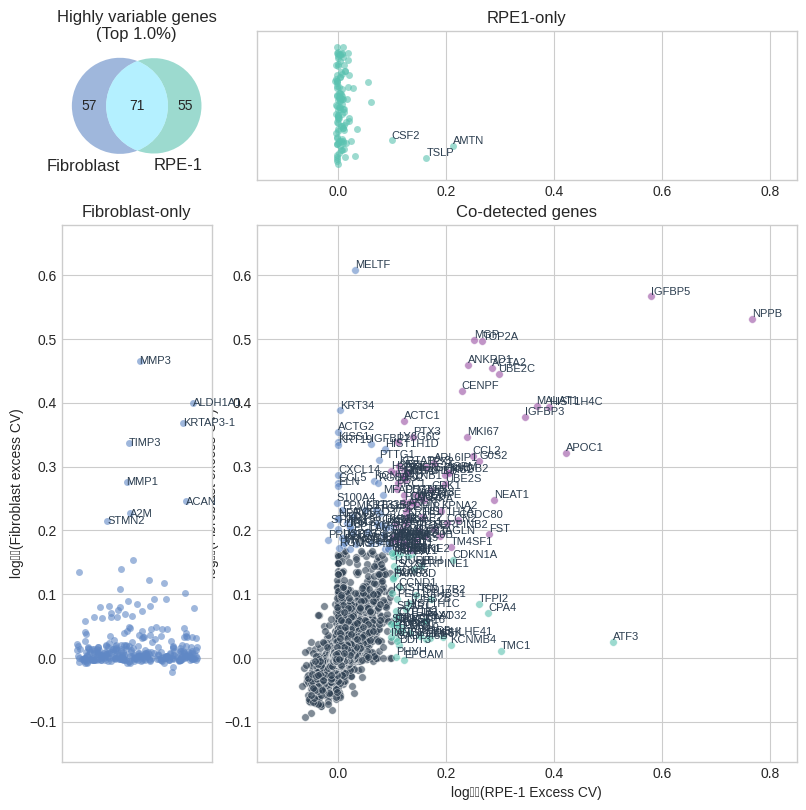

In [73]:
fig, gene_lists = create_publication_figure(df, quantile=0.99, log=True)

plt.savefig('fibro_vs_rpe1_excess_cv_all.pdf', dpi=300, bbox_inches='tight')


In [74]:
import pickle

# Save the dictionary to a pickle file
with open('gene_lists.pkl', 'wb') as f:
    pickle.dump(gene_lists, f)

# # Later, to load it back:
# with open('gene_lists.pkl', 'rb') as f:
#     loaded_gene_lists = pickle.load(f)

In [75]:
gene_lists

{'coexpressed_fibro_only_hits': ['ACTG2',
  'ADAMTS1',
  'ANKRD37',
  'CCL5',
  'CCNB2',
  'CD36',
  'CDCA8',
  'CDKN3',
  'CKS1B',
  'CRYAB',
  'CXCL14',
  'DEPDC1',
  'ELN',
  'FGF5',
  'GTSE1',
  'HERC5',
  'HIST1H1D',
  'IFIT3',
  'IGFBP2',
  'IGFBP7',
  'KCNMA1',
  'KISS1',
  'KRT19',
  'KRT33B',
  'KRT34',
  'KRT86',
  'KRTAP1-5',
  'MELTF',
  'MFAP5',
  'MMP11',
  'NPTX1',
  'NQO1',
  'PBK',
  'PCLAF',
  'PPME1',
  'PRDX6',
  'PRUNE2',
  'PSG5',
  'PTGS2',
  'PTTG1',
  'RGCC',
  'RGS5',
  'S100A4',
  'STMN1',
  'SULF1',
  'TMSB4X',
  'TUBA1B',
  'TYMS',
  'USP53'],
 'coexpressed_rpe1_only_hits': ['ANGPTL4',
  'ATF3',
  'BHLHE41',
  'CCND1',
  'CDKN1A',
  'CITED2',
  'CPA4',
  'CYP1B1',
  'DAB2',
  'DDIT3',
  'DKK1',
  'EDN1',
  'EGR1',
  'EPCAM',
  'FAM83D',
  'FBXO32',
  'FOS',
  'FOXQ1',
  'GADD45B',
  'GPRC5A',
  'H2AFX',
  'HES6',
  'HIST1H1C',
  'HJURP',
  'HSD17B2',
  'INHBB',
  'KCNMB4',
  'KIF11',
  'KIF23',
  'KNSTRN',
  'LBH',
  'MUSK',
  'MYL9',
  'NUF2',
  'PAPPA',
 

To focus on perturbation-induced variability, we look at the increase in excess CV in perturbed cells vs. controls.

In [76]:
df = pd.DataFrame([fibro_results_df.reindex(shared_genes)['fold_excess_cv'], rpe1_results_df.reindex(shared_genes)['fold_excess_cv']],
                 index=['fibro_excess_cv', 'rpe1_excess_cv']).T
df['gene_name'] = df.index

Note that there are some genes that then show *less* variability than expected. We don't focus on those in the paper but these are likely things that become "more regulated" in perturbed cells than in controls.

In [77]:
fibro_results_df.loc['LRRC15']

control_excess_cv      0.9975
active_excess_cv       1.0198
control_z             -0.2157
active_z               0.0565
diff_var_score         0.2722
control_expected_cv   18.6763
active_expected_cv    13.1795
fold_excess_cv         1.0223
Name: LRRC15, dtype: float64

/tmp/ipykernel_667241/689847385.py:306: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_667241/603186833.py:3: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  plt.savefig('fibro_vs_rpe1_excess_cv_control_normalized.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_667241/603186833.py:3: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Liberation Sans.
  plt.savefig('fibro_vs_rpe1_excess_cv_control_normalized.pdf', dpi=300, bbox_inches='tight')
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/norman/southark/software/conda/envs/scanpy_perturbseq/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUB

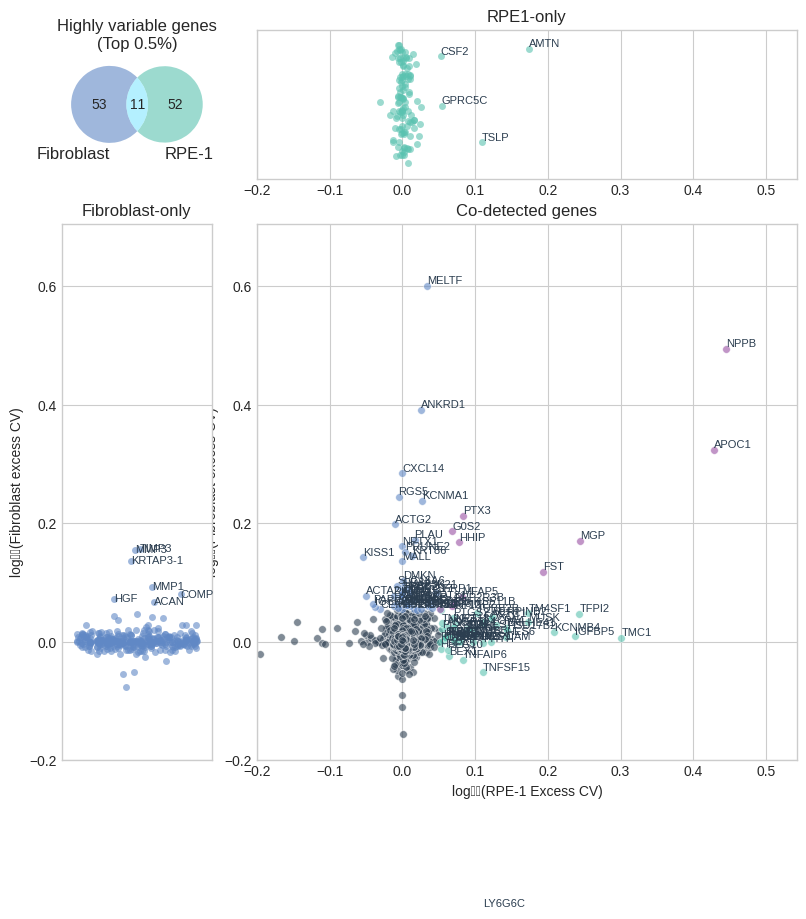

In [78]:
fig, gene_lists = create_publication_figure(df, quantile=0.995, log=True, vmin=-0.2)

plt.savefig('fibro_vs_rpe1_excess_cv_control_normalized.pdf', dpi=300, bbox_inches='tight')

In [79]:
df.to_csv('pvg_full_list.csv')

In [80]:
rpe1_results_df.loc['LRRC15']

control_excess_cv      1.0000
active_excess_cv       1.0000
control_z             -0.1236
active_z              -0.1455
diff_var_score        -0.0219
control_expected_cv   44.1861
active_expected_cv    28.3664
fold_excess_cv         1.0000
Name: LRRC15, dtype: float64

In [82]:
rpe1_df

,control_cv,active_cv,control_mean,active_mean
gene_name,,,,
FAM87B,116.9316,98.3209,-4.1359,-3.9853
FAM41C,9.0334,8.0729,-1.8928,-1.8092
SAMD11,11.0522,12.7618,-2.0828,-2.2144
NOC2L,1.7899,1.7543,-0.4777,-0.4593
KLHL17,8.7053,9.4393,-1.8758,-1.9322
...,...,...,...,...
MT-ND4,0.7526,0.7513,0.8718,0.8758
MT-ND5,1.0175,1.0322,0.2019,0.2079
MT-ND6,2.0599,2.0766,-0.5203,-0.5180


In [87]:
df['fibro_control_mean'] = fibro_df['control_mean']
df['fibro_active_mean'] = fibro_df['active_mean']
df['rpe1_control_mean'] = rpe1_df['control_mean']
df['rpe1_active_mean'] = rpe1_df['active_mean']

In [89]:
df.to_csv('full_excess_cv_with_mean.csv')

In [64]:
gene_lists['rpe1_specific_hits']

['AMTN', 'CSF2', 'GPRC5C', 'TSLP']

In [65]:
gene_lists['fibro_specific_hits']

['ACAN', 'COMP', 'HGF', 'KRTAP3-1', 'MMP1', 'MMP3', 'TIMP3']

In [66]:
gene_lists['coexpressed_shared_hits']

['AKAP12',
 'APOC1',
 'FST',
 'G0S2',
 'HHIP',
 'MFAP5',
 'MGP',
 'NPPB',
 'PPP2R3B',
 'PTX3',
 'TNFRSF11B']

In [67]:
[print(g) for g in gene_lists['coexpressed_rpe1_only_hits']]

ACTC1
ANGPTL4
BEX1
BHLHE41
CADM1
CLU
CNIH2
CPA4
DHRS9
DKK1
EPCAM
FOXQ1
GADD45B
H1F0
HES6
HSD17B2
HSPA5
HSPB3
IGFBP5
IL7R
INHBB
KCNMB4
KRT18
LY6G6C
MSMP
MUSK
MX1
PDE3A
PEG10
PHYH
PLAT
PLXNC1
PRRX2
PTGES
PTGS2
RIPPLY3
SERPINB2
SERPINE2
SOCS1
SRXN1
SULF1
TFPI2
TM4SF1
TMC1
TNFAIP6
TNFSF15
TNNC1
TUBB2B


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [68]:
[print(g) for g in gene_lists['coexpressed_fibro_only_hits']]

ABI3BP
ACTA2
ACTG2
ANGPT1
ANKRD1
CCL2
CD34
CD36
CEMIP
CFAP57
COL4A1
CRIP1
CTSC
CXCL14
DMKN
FTL
GBP4
HSF4
IFIT1
IGFBP2
IGFBP3
IGSF23
KCNMA1
KISS1
KRT81
KRT86
LRRC17
LTBP1
MALL
MAP3K21
MELTF
MMP11
NPTX1
PAPPA
PLAU
PLS1
PRUNE2
RAMP1
RGCC
RGS5
SCN3A
SFRP1
SLC16A6
TRBC2
TSPAN2
ZNF608


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# FAV RPE1 genes
1. CLU (https://www.proteinatlas.org/ENSG00000120885-CLU/single+cell/eye)-highy expressed in RPE
2. BCO2 (https://www.proteinatlas.org/ENSG00000197580-BCO2)-biosynthesis of vitamin A.-photoreceptors
3. SULF (https://www.proteinatlas.org/ENSG00000137573-SULF1) -extracellular heparan sulfate endosulfatase- brain enriched/muller glia and RPE
4. CRYAB (https://en.wikipedia.org/wiki/CRYAB) -heatshock-functions in maintaining lens clarity
5. BEX1 -neural lineage (https://www.proteinatlas.org/ENSG00000133169-BEX1)
6. SOX4/HES6 -neural TFs ? 

# FAV Fibro genes
1. ACTA2
COMP
LUM
ACAN LOX CD34
(MMP1, MMP3, MMP11, TIMP3) fibroblast activation